In [1]:
cd /home/dsi/mbouchouia/code/git/PRIM/Notebooks/

/home/dsi/mbouchouia/code/git/PRIM/Notebooks


In [2]:
import sklearn
import itertools

from sklearn.metrics import r2_score

from importlib import reload

import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import urllib

import time
import sys
import pymongo
import os
sys.path.append('../scripts/')
sys.path.append('../papers code/DCRNN/')
import Plotting
import folium
import matplotlib
import osmMerger
import CustomUtils
import OsmProcessing
import datetime
import pandas as pd
from tf_cuda_subprocess import *
from   functools import reduce
import seaborn as sns
import models
from mongoConnection import *
sns.set()
results_path = "../images/model results/"
def saveFig():
    if not os.path.isdir(results_path+model_name):
        os.makedirs(results_path+model_name)
    print(results_path+model_name)
    plt.savefig(results_path+model_name+input(),dpi=300,bbox_inches='tight')

import tensorflow as tf

# @RunAsCUDASubprocess(num_gpus=1)
def createSession():
    config = tf.ConfigProto(intra_op_parallelism_threads=8, 
                            inter_op_parallelism_threads=8,
                            allow_soft_placement=True,
                            log_device_placement=True
                           )

    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    session = tf.Session(config=config,graph=tf.get_default_graph())

    tf.keras.backend.set_session(session)
createSession()
oldModelPlotting=None

### \begin{equation} Y_c^{(i)} = Y^{(i)} - n^{-1} \sum_{i=1}^n{Y^{(i)}} \end{equation}

In [3]:
speeds = pd.read_pickle("../data/monthsSpeed__0.pckl")
counts = pd.read_pickle('../data/monthsCount__0.pckl')

In [4]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")
mergedSegments=pd.read_pickle("../data/mergedSegments.pckl")

In [5]:
data_cleaner = models.DataCleaner(speeds,segmentsMeta,mergeResults,counts,0.80)

In [6]:
diffusion_matrix = pd.read_pickle("../data/all_dates_diffusion_matrix.pckl")
diffusion_matrix = diffusion_matrix/diffusion_matrix.sum()

In [7]:
data_cleaner.data=data_cleaner.data.reindex(diffusion_matrix.index)
data_cleaner.counts=data_cleaner.counts.reindex(diffusion_matrix.index)

In [8]:
speedDF = data_cleaner.data
countDF = data_cleaner.counts

In [9]:
adjacency_matrix = OsmProcessing.getAdjacencyMatrix(segmentsMeta)
adjacency_matrix = adjacency_matrix.add(adjacency_matrix.T.values,fill_value=0)
adjacency_matrix = OsmProcessing.addLevel(adjacency_matrix,3)
adjacency_matrix = OsmProcessing.mergeAdjacencyMatrix(adjacency_matrix, mergeResults, segmentsMeta)
adjacency_matrix = adjacency_matrix[speedDF.index].loc[speedDF.index]

In [10]:
adfullerDF = speedDF.groupby(pd.to_datetime(speedDF.columns).time,axis=1).agg(lambda x :x.apply(lambda y : models.smt.adfuller(y.values)[1],axis=1))
print((adfullerDF<0.05).sum().sum()/adfullerDF.size)
print((adfullerDF>0.05).sum().sum())
# plt.figure(figsize=(18,18))
# plt.imshow((adfullerDF>0.05)+0,aspect='auto')
# plt.grid(b=None)
# plt.colorbar()

0.9492537313432836
544


In [11]:
""" we don't want to center using unseen data"""
valid_split = 0.7
sequence_length=20
n_dates=len(set(pd.to_datetime(speedDF.columns).date)) 
train_dates_index = speedDF.columns[:int(valid_split*n_dates)*sequence_length]
train_intercept=speedDF[train_dates_index].groupby(pd.to_datetime(train_dates_index).time,axis=1).mean()
intercept_extended_df= pd.concat([train_intercept]*n_dates,axis=1)
intercept_extended_df.columns=speedDF.columns
# centering
speedDF=speedDF-intercept_extended_df

In [12]:
s=speedDF.loc[adfullerDF.mean(axis=1)>0.06] + intercept_extended_df.loc[adfullerDF.mean(axis=1)>0.06]

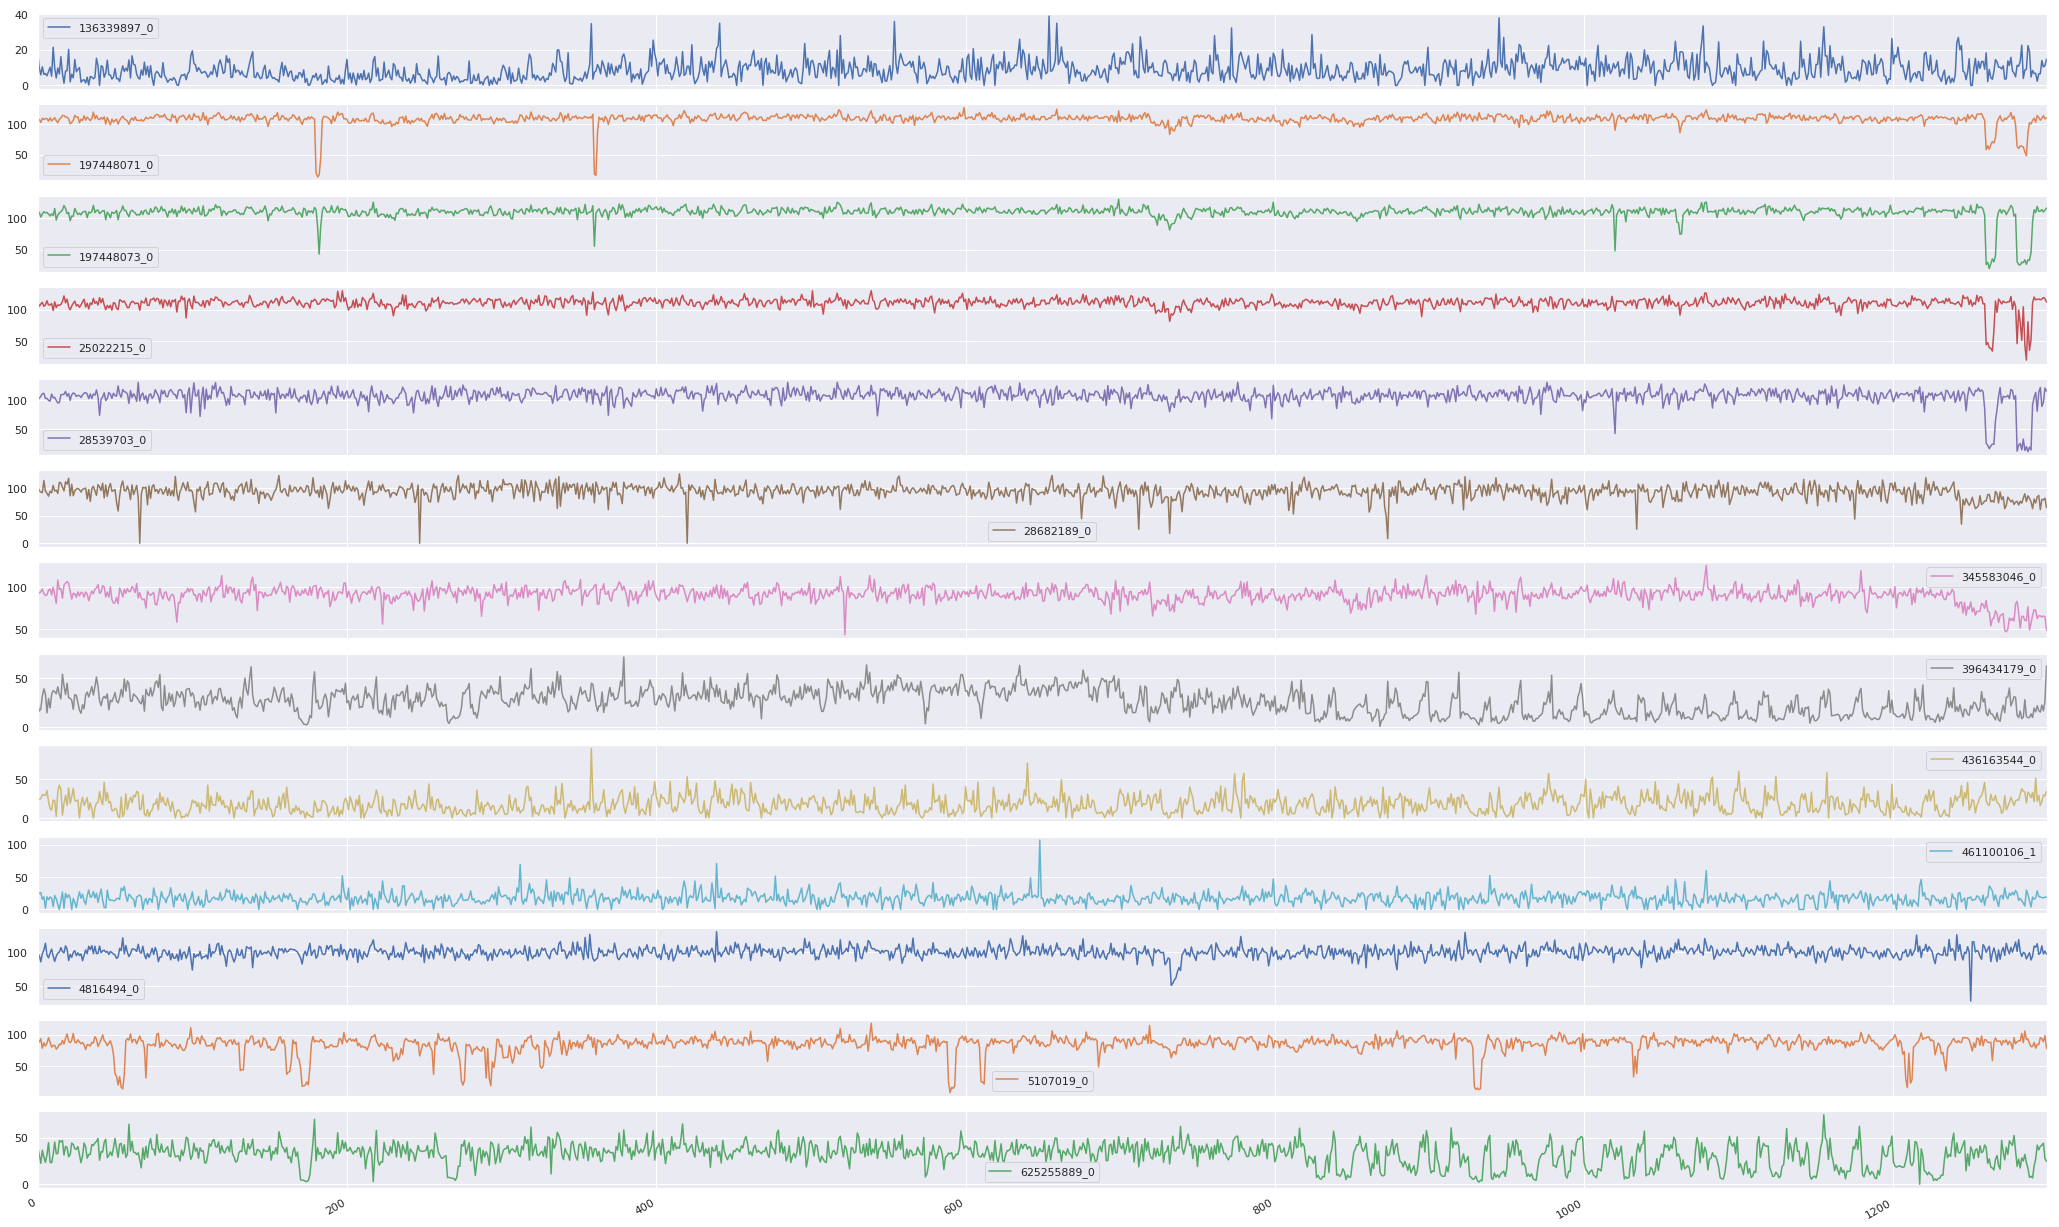

In [13]:
""" non-stationary segments plots"""
s.T.plot(figsize=(36,24),use_index=False,subplots=True);

In [14]:
def simpleMonoInput(data_model,x_train,l1_rate):
    """
    params        = { "shift_mean":True, "scale_output":True}

    97.82098577640886 104.90778000413427
    
    6.814727330233829 7.017203929831204
    
    """
    
#     time_dense = tf.keras.layers.Dense( nSegments, use_bias=False )(time_input)
    
    
    
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )

#     hidden = tf.keras.layers.Dense(200, use_bias = True, kernel_regularizer=tf.keras.regularizers.l1(l1_rate))(flatten_input)

    output_layer = tf.keras.layers.Dense(nSegments , name = "Output", use_bias = False, kernel_regularizer = tf.keras.regularizers.l1(l1_rate))(flatten_input)
    
    data_model.model = tf.keras.Model( inputs = [ main_input ], outputs= [ output_layer ])
    
    optimizer = tf.keras.optimizers.Adam()
    
    data_model.model.compile( loss = "mse", optimizer = optimizer, metrics = ['mae'] )

    data_model.model.summary()
    

In [15]:
nSegments = len(speedDF)

input_lag, output_lag, sequence_length = 1, 1, 20 # speedDF.columns.size
valid_split = 0.7

params        = { "scale_output" : True}

data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params)

data_model.preprocessData()

x_train_00, y_train_00, x_test_00, y_test_00 = data_model.trainSplit()

count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
count_train_00, _, count_test_00, _ = count_data.trainSplit()

tf.keras.backend.clear_session()
# data_model.count_data = count_data

data_model.time_data  =  data_model.getDaysTypes(onehot=True)

train_days_00, test_days_00 =  data_model.getDaysTypes(onehot=True)

simpleMonoInput(data_model,x_train_00,l1_rate=0.08)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speed_input (InputLayer)     (None, 1, 536)            0         
_________________________________________________________________
lambda (Lambda)              (None, 536)               0         
_________________________________________________________________
Output (Dense)               (None, 536)               287296    
Total params: 287,296
Trainable params: 287,296
Non-trainable params: 0
_________________________________________________________________


In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor = 'loss', factor = 0.8, verbose=1, patience=5, cooldown=15)
early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_mean_absolute_error', patience = 10, restore_best_weights=True )

batch_size = 8

modelHist = data_model.model.fit([x_train_00,train_days_00], [y_train_00], validation_data=([x_test_00,test_days_00],y_test_00), batch_size=batch_size,epochs=400,callbacks=[reduce_lr,early_stop])
print(data_model.mse(data_model.predict('train'), y_train_00), data_model.mse(data_model.predict('test'),y_test_00))
print(data_model.mae(data_model.predict('train'), y_train_00), data_model.mae(data_model.predict('test'),y_test_00))

Train on 864 samples, validate on 371 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/400
864/864 [==============================] - 0s 509us/sample - loss: 581.2145 - mean_absolute_error: 8.7367 - val_loss: 245.5155 - val_mean_absolute_error: 7.3889
Epoch 2/400
864/864 [==============================] - 0s 316us/sample - loss: 157.9344 - mean_absolute_error: 6.8001 - val_loss: 135.7031 - val_mean_absolute_error: 7.0391
Epoch 3/400
864/864 [==============================] - 0s 323us/sample - loss: 124.7756 - mean_absolute_error: 6.7545 - val_loss: 129.4939 - val_mean_absolute_error: 6.9790
Epoch 4/400
864/864 [==============================] - 0s 345us/sample - loss: 122.5088 - mean_absolute_error: 6.7320 - val_loss: 127.7059 - val_mean_absolute_error: 6.9676
Epoch 5/400
864/864 [==============================] - 0s 299us/sample - loss: 121.3317 - mean_absolute_error: 6.7245 - val_loss: 128.6783 - val_mean_absolute_error: 6.9398
Epoch 6/400
864/864 [====================

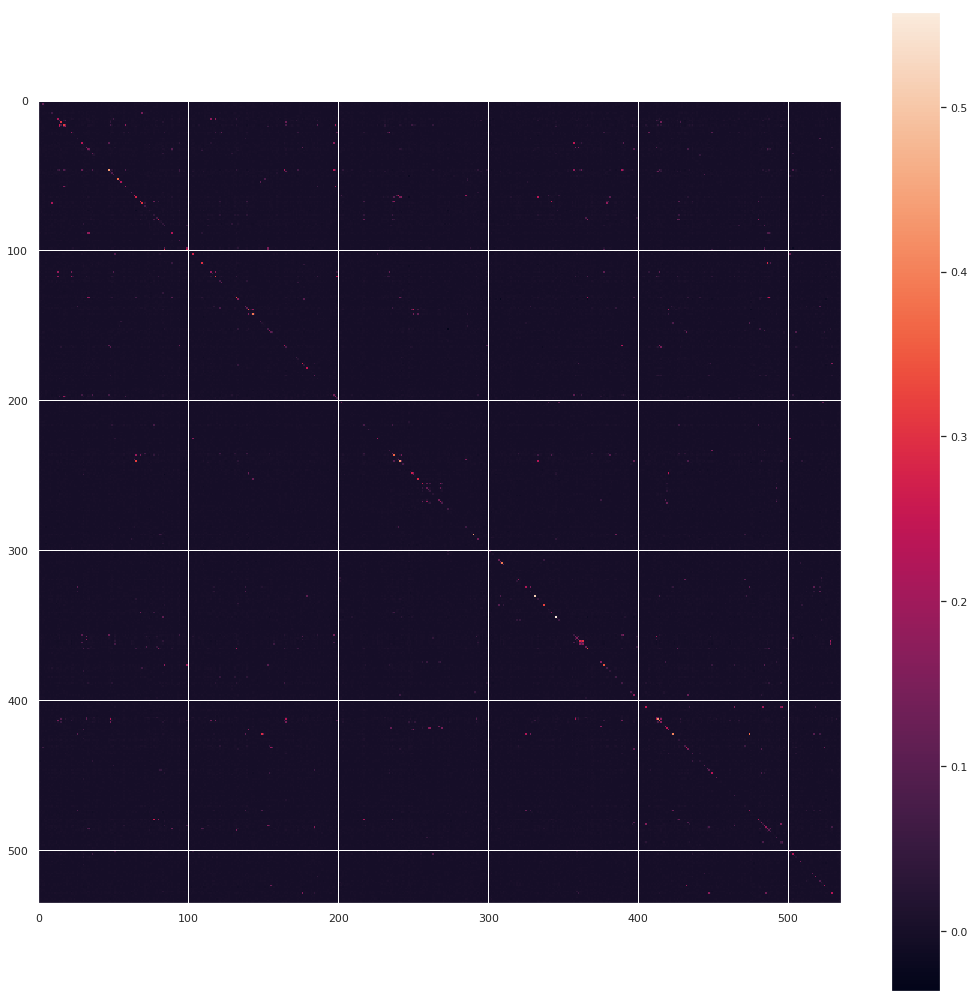

In [17]:
plt.figure(figsize=(18,18))
A = data_model.model.get_weights()[0]
plt.imshow(A)
plt.colorbar()

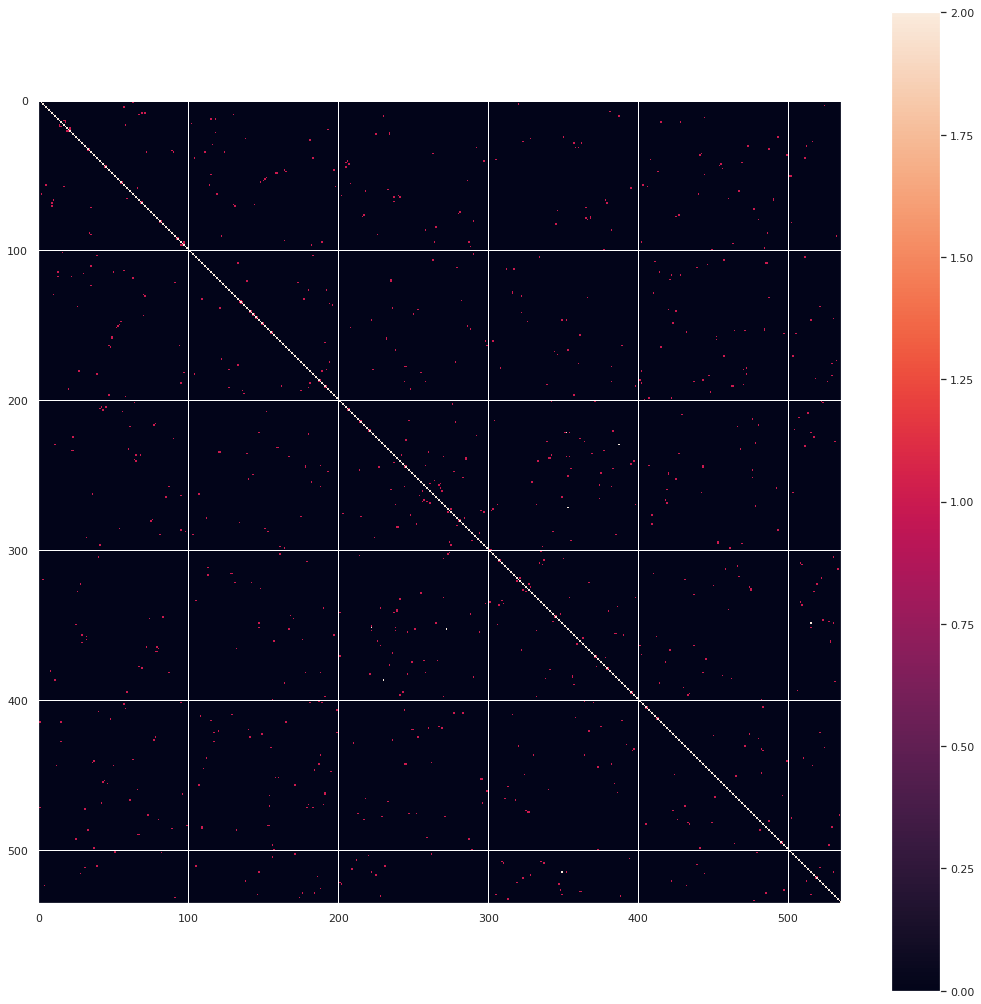

In [18]:
plt.figure(figsize=(18,18))
plt.imshow((adjacency_matrix-3).clip(0))
plt.colorbar()

# A matrix for each time

In [19]:
t_interval_length = 2
overlapping = True
t_index  = np.unique(pd.to_datetime(speedDF.columns).time)

index_subsets = np.split(t_index,range(t_interval_length,len(t_index),t_interval_length)) if not overlapping else np.array([np.array([t_index[i]  for i in range(j,t_interval_length+j)]) for j in range(len(t_index)-t_interval_length+1)])
index_subsets = [ pd.Index(pd.to_datetime(speedDF.columns).time).isin(subset) for subset in index_subsets]

K = tf.keras.backend

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

def smape_loss(true, predicted):
    """
    Differentiable SMAPE loss
    :param true: Truth values
    :param predicted: Predicted values
    :param weights: Weights mask to exclude some values
    :return:
    """
    epsilon = 0.1 # Smoothing factor, helps SMAPE to be well-behaved near zero
    
    true_o  = true
    pred_o  = predicted
    
    summ    = tf.maximum(tf.abs(true_o) + tf.abs(pred_o) + epsilon, 0.5+ epsilon)
    smape   = tf.abs(pred_o - true_o) / summ * 2.0
    
    return smape

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return -(1 - SS_res/(SS_tot + K.epsilon()))

A_t = []
losses = []
maes=[]

try:
    err_rates
except Exception:
    err_rates =np.zeros(len(index_subsets))

for i,subset in enumerate(index_subsets) : 
    
    X = speedDF[speedDF.columns[subset]].copy()
    
    nSegments = len(X)
    input_lag, output_lag, sequence_length = 1, 1, t_interval_length # speedDF.columns.size
    valid_split = 0.7

    params        = { "scale_output" : True}
    A_t_model    = models.DataModel( X,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params)                                                

    A_t_model.preprocessData()

    x_train_00, y_train_00, x_test_00, y_test_00 = A_t_model.trainSplit()

    count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
    count_train_00, _, count_test_00, _ = count_data.trainSplit()

    tf.keras.backend.clear_session()
    # A_t_model.count_data = count_data

    A_t_model.time_data  =  A_t_model.getDaysTypes(onehot=True)

    train_days_00, test_days_00 =  A_t_model.getDaysTypes(onehot=True)

    simpleMonoInput(A_t_model,x_train_00,l1_rate=0.08+err_rates[i])
    print( "reg rate : ",0.05+err_rates[i])
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor = 'loss', factor = 0.8, verbose=0, patience=5, cooldown=15)
    early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_mean_absolute_error', patience = 10, restore_best_weights=True )
    batch_size = 8

    modelHist = A_t_model.model.fit([x_train_00,train_days_00], [y_train_00], validation_data=([x_test_00,test_days_00],y_test_00),verbose=0, batch_size=batch_size,epochs=400,callbacks=[reduce_lr,early_stop])
    print(A_t_model.mse(A_t_model.predict('train'), y_train_00), A_t_model.mse(A_t_model.predict('test'),y_test_00))
    print(A_t_model.mae(A_t_model.predict('train'), y_train_00), A_t_model.mae(A_t_model.predict('test'),y_test_00))
    losses.append([A_t_model.mse(A_t_model.predict('train'), y_train_00), A_t_model.mse(A_t_model.predict('test'),y_test_00),A_t_model.mae(A_t_model.predict('train'), y_train_00), A_t_model.mae(A_t_model.predict('test'),y_test_00)])   
    A_t.append((A_t_model.model.get_weights()[0]>0.01)+0)
    maes.append(A_t_model.mae(A_t_model.predict('test'),y_test_00))
A_t = np.array(A_t)
losses=np.array(losses)
err_rates  +=((losses[:,3]-losses[:,2])-0.3).clip(min=0)/50

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speed_input (InputLayer)     (None, 1, 536)            0         
_________________________________________________________________
lambda (Lambda)              (None, 536)               0         
_________________________________________________________________
Output (Dense)               (None, 536)               287296    
Total params: 287,296
Trainable params: 287,296
Non-trainable params: 0
_________________________________________________________________
reg rate :  0.05
40.66897245901766 99.88608546838965
4.640329853109623 6.652651499699611
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speed_input (InputLayer)     (None, 1, 536)            0         
_________________________________________________________________
lambda (Lambda)              (None, 536)       

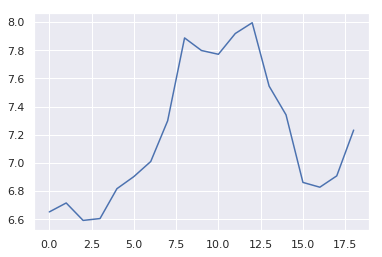

In [20]:
plt.plot(maes)

Text(0.5, 1.0, 'Number of Ones for each matrix At')

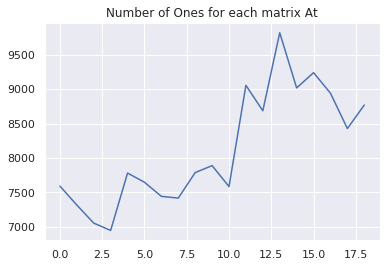

In [21]:
# number of  ones
plt.plot(np.sum( A_t, (1,2)))
plt.title("Number of Ones for each matrix At")

Text(0.5, 1.0, 'number of 1-matches between At matrices')

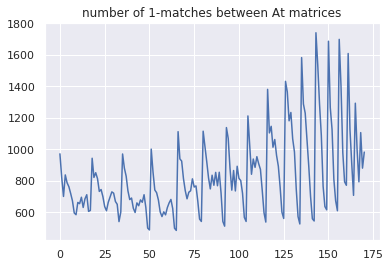

In [22]:
one_matches= np.array([np.sum(A_t[i]+A_t[j]==2)  for i, j in list(itertools.combinations(range(len(A_t)),2))])

mismatches=np.array([np.sum(abs(A_t[i]-A_t[j]))  for i, j in list(itertools.combinations(range(len(A_t)),2))])
# plt.plot(mismatches)
plt.plot(one_matches)
plt.title("number of 1-matches between At matrices")

### baseline comparison 

In [23]:

params        = {}

lastValue_data_model = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
lastValue_data_model.preprocessData()

model = models.BaseModels("lastValue",historic_data = speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]])
lastValue_data_model.model=model
lastValue_model_plotting = models.ModelPlots(lastValue_data_model, data_cleaner)


In [24]:

params        = {}

timehistoric_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
timehistoric_data_model.preprocessData()

model =models.BaseModels("timeHistoric",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]])
timehistoric_data_model.model=model


In [25]:

params        = {}

historic_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
historic_data_model.preprocessData()

model =models.BaseModels("historic",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]])
historic_data_model.model=model


In [26]:
params        = {}

AR5_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
AR5_data_model.preprocessData()

model =models.BaseModels("AR5",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]],lag=input_lag)
AR5_data_model.model=model


Training the AR(5) model
Train data shape: (536, 909)

Filling the voids...
Filling done. New train data shape: (536, 6921)

Training the models...
Params: max_lag: 1


/home/infres/mbouchouia/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)



Training finished !


In [27]:
# mlp_model_plotting = models.ModelPlots(mlpModel, data_cleaner, split="test", y=data_model.getRawYData(y_test_00))

# lastValue_model_plotting = models.ModelPlots(lastValue_data_model,data_cleaner,split="train",y=data_model.getRawYData(y_train_00))
# historic_model_plotting = models.ModelPlots(historic_data_model,data_cleaner,split="train",y=data_model.getRawYData(y_train_00))
# timehistoric_model_plotting = models.ModelPlots(timehistoric_data_model,data_cleaner,split="train",y=data_model.getRawYData(y_train_00))
# AR5_model_plotting = models.ModelPlots(AR5_data_model,data_cleaner,split="train",y=data_model.getRawYData(y_train_00))
# model_plotting = models.ModelPlots(data_model,data_cleaner,split="train",y=data_model.getRawYData(y_train_00))

intercept_data_model = models.DataModel(intercept_extended_df,input_lag,output_lag,sequence_length,valid_split=valid_split)
intercept_data_model.preprocessData()

lastValue_model_plotting = models.ModelPlots(lastValue_data_model,data_cleaner,split="test",y = data_model.getRawYData(y_test_00.copy()),intercept_data_model=intercept_data_model)
historic_model_plotting = models.ModelPlots(historic_data_model,data_cleaner,split="test",y = data_model.getRawYData(y_test_00.copy()),intercept_data_model=intercept_data_model)
timehistoric_model_plotting = models.ModelPlots(timehistoric_data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00.copy()),intercept_data_model=intercept_data_model)
AR5_model_plotting = models.ModelPlots(AR5_data_model,data_cleaner,split="test",y = data_model.getRawYData(y_test_00.copy()),intercept_data_model=intercept_data_model)
model_plotting = models.ModelPlots(data_model, data_cleaner, split="test", y = data_model.getRawYData(y_test_00.copy()), intercept_data_model=intercept_data_model)


ValueError: operands could not be broadcast together with shapes (20,536) (196,536) (20,536) 

In [ ]:
model_plotting = models.ModelPlots(data_model,data_cleaner, split="test", y = data_model.getRawYData(y_test_00.copy()), intercept_data_model=intercept_data_model)

In [ ]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")

historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR")
model_plotting.plotDiscreteSpeedError(ax,"Current model")

if not oldModelPlotting is None :
    oldModelPlotting.plotDiscreteSpeedError(ax,"old")
else :
    oldModelPlotting=model_plotting
ax.twinx()
plt.plot(*np.unique((data_model.trainSplit()[3]+intercept_data_model.trainSplit()[3]).flatten().round(),return_counts=True), 'k:', linewidth=2,label="count", alpha=0.4);
plt.ylabel("counts")


In [ ]:
oldModelPlotting = model_plotting

In [ ]:
def get_kepler_plotable_data(segmentsMeta,speedDF,At):
    submeta = segmentsMeta.copy()
    submeta=submeta.set_index("segmentID").loc[speedDF.index]
    loc_idx = submeta['loc'].apply(lambda x : x['coordinates'][len(x['coordinates'])//2][0]).values
    df =pd.DataFrame(np.array([loc_idx]*len(speedDF)).flatten(),columns=['long_r'])
    df = df.assign(long_l=pd.Series(loc_idx , index=range(0,nSegments**2,nSegments)))
    df=df.assign(segmentId_r = np.array([speedDF.index.values]*len(speedDF)).flatten())

    loc_idx=submeta['loc'].apply(lambda x : x['coordinates'][len(x['coordinates'])//2][1]).values
    df = df.assign(lat_r=np.array([loc_idx]*len(speedDF)).flatten() )
    df = df.assign(lat_l=pd.Series(loc_idx,index=range(0,nSegments**2,nSegments)))
    df= df.assign(segmentId_l=pd.Series(speedDF.index.values,index=range(0,nSegments**2,nSegments)))
    df= df.ffill()

    df=df.assign( rate = At.flatten() )
    return df

df = get_kepler_plotable_data(segmentsMeta,speedDF,A)


df=df.assign( adjacency = adjacency_matrix.values.flatten() )

df=df.assign( diffusion = diffusion_matrix.values.flatten() )

df.to_csv("../data/segment_flow.csv")